# Read Files to WordCloud

### Notes

#### Scenarios:
1. Single file -> Single word cloud
2. Multiple files -> Single word cloud
3. Multiple files -> Multiple word clouds + Combined word cloud

#### Instructions:
1. Run the entire file: From the menu, select `Runtime` then `Run all`

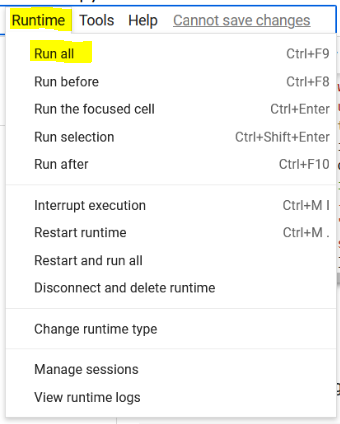
2. Upload your files to the `data` folder

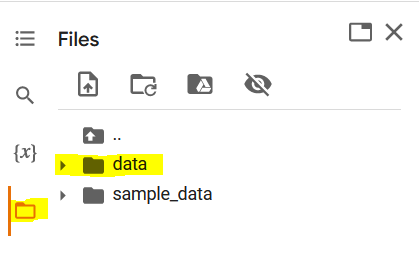
3. Set the appropriate parameters by toggling the **Yes/No** buttons in the "Settings" cell.

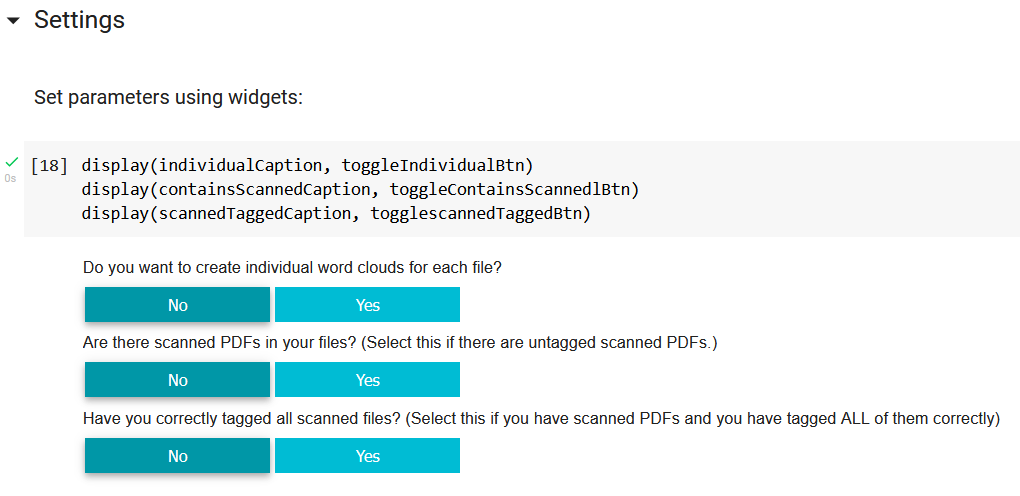
4. Click `Run` and wait for the word clouds to be generated. Wait till you see the message **### Done ###** in the cell logs, or a wordcloud with the title **"Combined Word Cloud"**.
5. Click `Download` to get a zip file of your word cloud images.

#### Limitations:
* Text in images cannot be read. Here is a [workaround](https://www.thewindowsclub.com/extract-text-from-an-image-in-word) to extract text from images.
* Scanned PDFs _(You know a PDF was scanned if you can't select text with your mouse when you open it normally)_
    * SOTA OCR methods are still not perfect
    * OCR text recognition takes longer to run
    * \*Key takeaway: If you can get a machine-generated PDF, use that, else tag your **scanned PDF** files properly by renaming them to end with `_scanned.pdf`

#### Known Issues:
* Sometimes, the required packages fail to install correctly, leading to an error in the logs that says: `ERROR: module 'PIL.Image' has no attribute 'Transpose'`. In this scenario, go to `Runtime` in the menu, and select `Restart and run all`. 
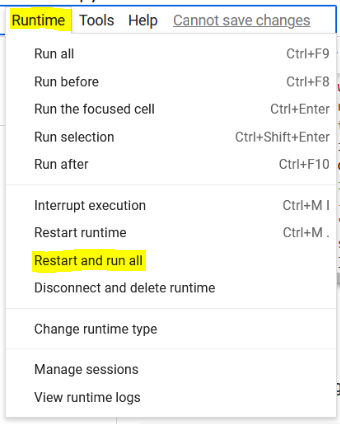

This should fix the problem, and you can go through the steps outlined in the instructions.

---

### Installations

Install necessary libraries:  
* **iPython Widgets** - For creating buttons
* **NLTK** - For basic NLP, like getting stop words
* **PDF Plumber** - For reading machine generated PDFs
* **PyMuPDF (fitz)** - For reading scanned PDFs
* **PyTesseract** - For OCR in conjunction with fitz pages
* **TQDM** - Progress bar

In [11]:
!pip install ipywidgets -q
!pip install nltk -q
!pip install pdfplumber -q
!pip install pymupdf -q
!pip install pytesseract -q
!pip install tqdm -q

In [12]:
!sudo apt -qq update
!sudo apt -qq install tesseract-ocr
!sudo apt -qq install libtesseract-dev

52 packages can be upgraded. Run 'apt list --upgradable' to see them.
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.


### Imports

Import libraries

In [13]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import zipfile

import fitz
import ipywidgets as widgets
import nltk
import pdfplumber
import pytesseract

from collections import Counter
from google.colab import files
from IPython.display import clear_output
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from wordcloud import WordCloud

### Code

Download NLTK stopwords

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Parameter defaults

In [15]:
if not os.path.isdir('./data'):
        os.mkdir('data')

DATA_PATH = "./data"
INDIVIDUAL_WORD_CLOUDS = False
CONTAINS_SCANNED_PDFS = False # Set to true if you know your data contains scanned documents, but you cannot specify which are scanned
SCANNED_PDFS_TAGGED = False # Only set to True if you have named ALL scanned PDFs correctly i.e. file name ends with _scanned.pdf

Main functions

In [16]:
def read_file(file_path: str) -> str:
    file_string = ""
    try:
        # PDF
        if file_path.endswith('.pdf'):
            if SCANNED_PDFS_TAGGED: #Assumed that you know which ones were scanned
                if file_path.endswith("_scanned.pdf"): #These were scanned
                    doc = fitz.open(file_path)
                    for page in doc:
                        pix = page.get_pixmap()
                        output = "outfile.png"
                        pix.save(output)
                        file_string += (pytesseract.image_to_string('outfile.png').lower() + " ")
                        os.remove("./outfile.png") 
                else: #These were not scanned
                    with pdfplumber.open(file_path) as pdf:
                        for page in pdf.pages:
                            file_string += (page.extract_text().lower() + " ")
            elif CONTAINS_SCANNED_PDFS: # Assumed that you DON'T know which were scanned, but you know that there ARE scanned documents
                # Treat everything like it was scanned
                doc = fitz.open(file_path)
                for page in doc:
                    pix = page.get_pixmap()
                    output = "outfile.png"
                    pix.save(output)
                    file_string += (pytesseract.image_to_string('outfile.png').lower() + " ")
                    os.remove("./outfile.png") 
            else: # You know nothing was scanned
                with pdfplumber.open(file_path) as pdf:
                    for page in pdf.pages:
                        file_string += (page.extract_text().lower() + " ")
        # Word Document
        elif file_path.endswith(('.doc', '.docx')):
            docx = zipfile.ZipFile(file_path)
            file_string = docx.read('word/document.xml').decode('utf-8')
            file_string = re.sub('<(.|\n)*?>','',file_string).lower()
        # Plain Text
        else:
            with open(file_path, 'r') as f:
                file_string = f.read().lower()
    except Exception as e:
        print(f"Error: {e}")
    finally:
        return file_string
  

def create_word_cloud(text, title):
    # Removing non-alphanumeric characters in string
    re_pattern = re.compile(r'[^\w\s]', re.UNICODE)
    text = re_pattern.sub('', text)

    # Remove unnecessary words (stop words) like "the", "and", etc.
    words_to_count = text.split() # Split sentence into list of words
    stop_word_set = set(stopwords.words('english'))
    words_to_count = [word for word in words_to_count if word not in stop_word_set] # Remove stop words

    # Count the words using Python's Counter
    word_cloud_dict = Counter(words_to_count)

    # Save word counts to CSV file
    pd.DataFrame(word_cloud_dict, columns=["word", "count"]).to_csv(f"./output/{title}.csv", index=False)

    # Create the word cloud from the counted words
    try:
        wordcloud = WordCloud(
                      max_font_size=40, 
                      background_color="white"
                    ).generate_from_frequencies(word_cloud_dict)

        # Display the generated image:
        plt.figure(figsize=(16, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title)
        plt.savefig(f"./output/{title}.png")
        plt.show()
    except Exception as e:
        print(f"ERROR: {e}")
        print("IT APPEARS YOU TRIED TO RUN THIS SCRIPT ON A SCANNED OR EMPTY DOCUMENT WITHOUT THE RIGHT PARAMETERS!")
        print()
        print("Things to check...")
        print("1. Make sure the data folder contains at least one file")
        print("2. If you know which PDFs are scanned, rename them to end with _scanned.pdf, and set SCANNED_PDFS_TAGGED to True")
        print("3. If you do not know which PDFs are scanned, set CONTAINS_SCANNED_PDFS to True")

Create Widgets

In [17]:
convert_yes_no = {
    "yes": True,
    "no": False
}

# Create Individual Word Clouds
individualCaption = widgets.Label(value="Do you want to create individual word clouds for each file?")
toggleIndividualBtn = widgets.ToggleButtons(
    options=["No", "Yes"],
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
)
def handleToggleIndividualBtnChange(change):
  global INDIVIDUAL_WORD_CLOUDS
  INDIVIDUAL_WORD_CLOUDS = convert_yes_no[change.new.lower()]
toggleIndividualBtn.observe(handleToggleIndividualBtnChange, names='value')

# Scanned PDF's contained?
containsScannedCaption = widgets.Label(value="Are there scanned PDFs in your files? (Select this if there are untagged scanned PDFs.)")
toggleContainsScannedlBtn = widgets.ToggleButtons(
    options=["No", "Yes"],
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
)
def handleToggleContainsScannedlBtnChange(change):
  global CONTAINS_SCANNED_PDFS
  CONTAINS_SCANNED_PDFS = convert_yes_no[change.new.lower()]
toggleContainsScannedlBtn.observe(handleToggleContainsScannedlBtnChange, names='value')

# Scanned PDFs tagged?
scannedTaggedCaption = widgets.Label(value="Have you correctly tagged all scanned files? (Select this if you have scanned PDFs and you have tagged ALL of them correctly)")
togglescannedTaggedBtn = widgets.ToggleButtons(
    options=["No", "Yes"],
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
)
def handleTogglescannedTaggedBtnChange(change):
  global SCANNED_PDFS_TAGGED
  SCANNED_PDFS_TAGGED = convert_yes_no[change.new.lower()]
togglescannedTaggedBtn.observe(handleTogglescannedTaggedBtnChange, names='value')

# Run button
runButton = widgets.Button(
    description="Run",
    button_style='success')
def on_run_button_clicked(b):
    clear_output(wait=True)
    display(runButton)
    combined_file_text = ""
    if not os.path.isdir('output'):
        os.mkdir('output')
    for file_path in tqdm([f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]):
        file_path = join(DATA_PATH, file_path)
        print(file_path)
        print("Running...")
        file_text = read_file(file_path)
        if INDIVIDUAL_WORD_CLOUDS:
            create_word_cloud(file_text, file_path.split("/")[-1])
        combined_file_text += file_text
    print("Combined Word Cloud")
    create_word_cloud(combined_file_text, "Combined Word Cloud")
    print("### DONE ###")
runButton.on_click(on_run_button_clicked)

# Download button
downloadButton = widgets.Button(
    description="Download",
    button_style='success')
def on_download_button_clicked(b):
    clear_output(wait=True)
    display(downloadButton)
    # Download all images as zip file
    os.system("zip -r /content/WordClouds.zip /content/output")
    files.download("/content/WordClouds.zip")
    print("### Files Downloaded ###")
downloadButton.on_click(on_download_button_clicked)

### Settings

Set parameters using widgets:

In [18]:
display(individualCaption, toggleIndividualBtn)
display(containsScannedCaption, toggleContainsScannedlBtn)
display(scannedTaggedCaption, togglescannedTaggedBtn)

Label(value='Do you want to create individual word clouds for each file?')

ToggleButtons(button_style='info', options=('No', 'Yes'), value='No')

Label(value='Are there scanned PDFs in your files? (Select this if there are untagged scanned PDFs.)')

ToggleButtons(button_style='info', options=('No', 'Yes'), value='No')

Label(value='Have you correctly tagged all scanned files? (Select this if you have scanned PDFs and you have t…

ToggleButtons(button_style='info', options=('No', 'Yes'), value='No')

### Run

Run

In [19]:
display(runButton)

Button(button_style='success', description='Run', style=ButtonStyle())

### Download

In [20]:
display(downloadButton)

Button(button_style='success', description='Download', style=ButtonStyle())